In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [12]:
import zipfile

z= zipfile.ZipFile('data/chest_xray.zip')
z.extractall()

In [13]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.image as mpimg

# %tensorflow_version 2.x  # Only needed in Google Colab
import tensorflow as tf

# Check GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print('GPU device not found, using CPU instead.')
    tf.config.set_visible_devices([], 'GPU')
else:
    print(f'Found GPU at: {physical_devices[0]}')

print('TensorFlow version:', tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions


GPU device not found, using CPU instead.
TensorFlow version: 2.17.0


# Loading the dataset

In [18]:
import os
import cv2
import numpy as np

def get_data(data_dir, img_size=(128, 128)):
    data = []
    labels = []
    
    # Iterate through each category (e.g., 'PNEUMONIA' and 'NORMAL')
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        label = 0 if category == 'NORMAL' else 1  # Assuming binary classification

        # Iterate through each image file in the category
        for img_name in os.listdir(category_path):
            try:
                # Load the image file
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                
                # Resize the image to the desired size
                img = cv2.resize(img, img_size)
                
                # Normalize the image data
                img = img / 255.0
                
                # Append the processed image and label to the data list
                data.append(img)
                labels.append(label)
                
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
    
    # Convert the lists to NumPy arrays
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    return data, labels

# Example Usage
train_data, train_labels = get_data('chest_xray/train')
test_data, test_labels = get_data('chest_xray/test')
val_data, val_labels = get_data('chest_xray/val')

print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")


Train data shape: (5216, 128, 128, 3), Train labels shape: (5216,)
Test data shape: (624, 128, 128, 3), Test labels shape: (624,)
Validation data shape: (16, 128, 128, 3), Validation labels shape: (16,)


# Data Visualization and Preprocessing

In [19]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

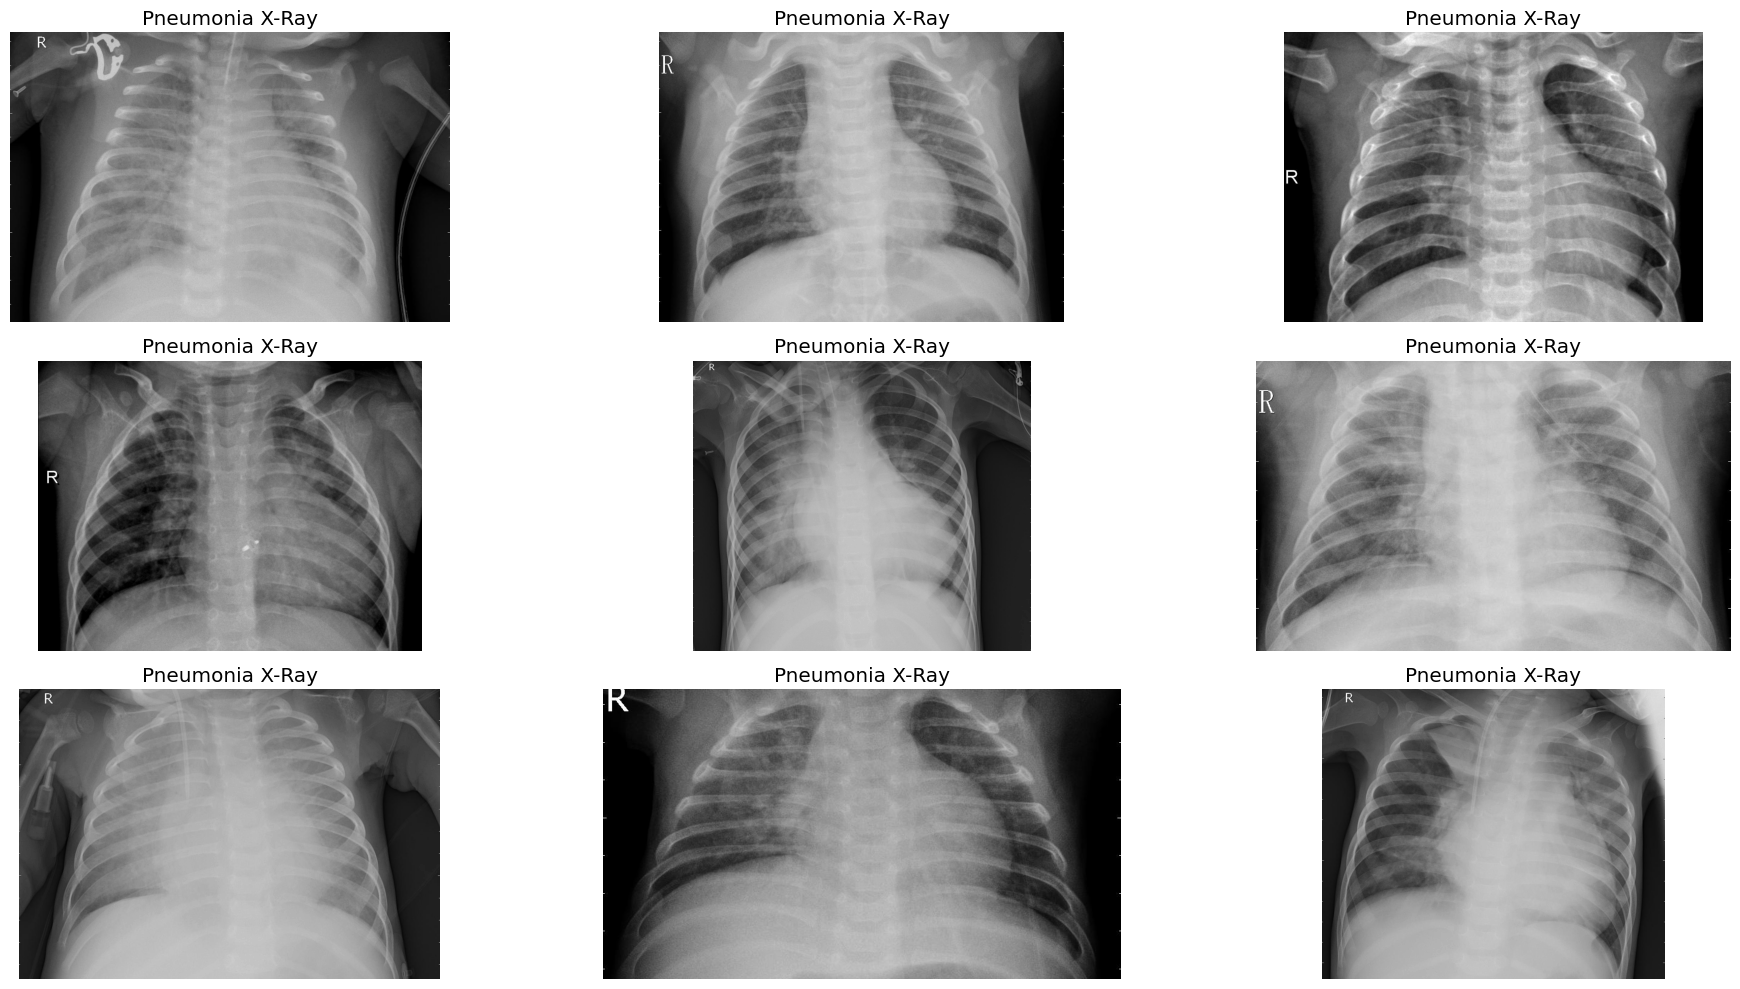

In [20]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()
plt.savefig("outputs/pneumonia_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

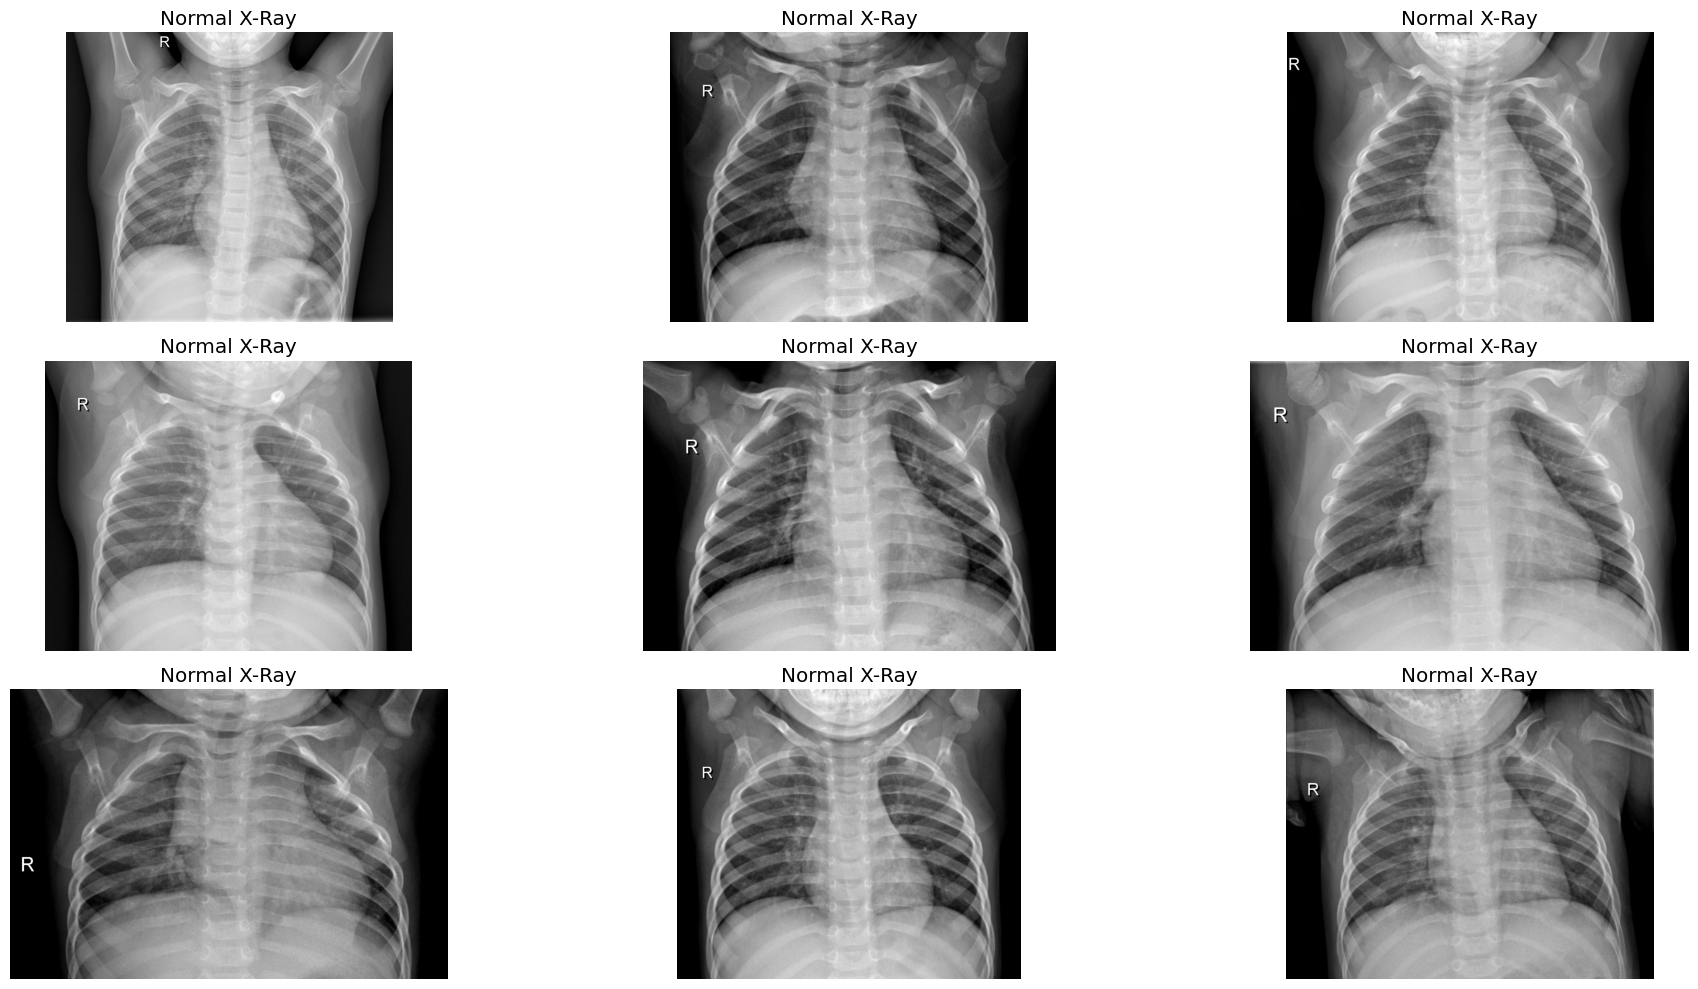

In [21]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()
plt.savefig("outputs/normal_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

<Axes: xlabel='count'>

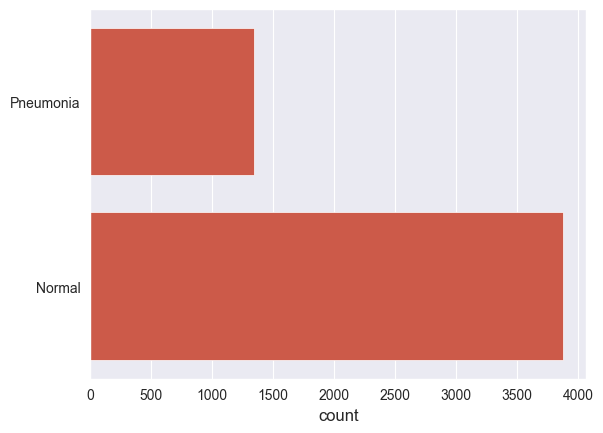

In [24]:
import seaborn as sns

# Assume train_labels contains the labels (0 for Pneumonia, 1 for Normal)
listx = []

# Iterate over the labels, not the image data
for label in train_labels:
    if label == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")

# Plotting the distribution of the labels
sns.set_style('darkgrid')
sns.countplot(listx)


Text(0.5, 1.0, 'Label: Normal')

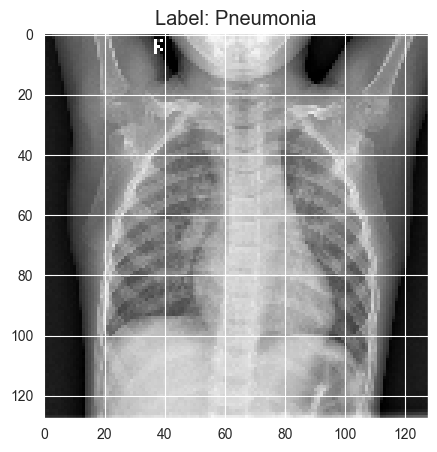

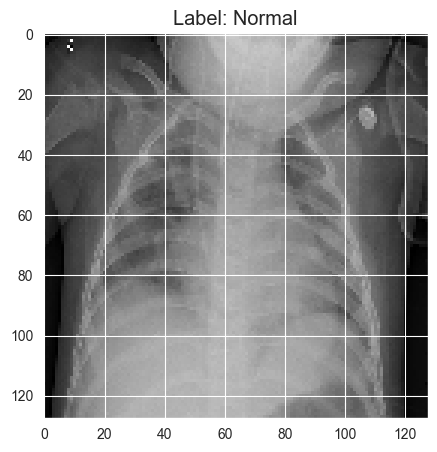

In [26]:
plt.figure(figsize=(5, 5))
plt.imshow(train_data[0], cmap='gray')
plt.title("Label: " + ("Pneumonia" if train_labels[0] == 0 else "Normal"))

plt.figure(figsize=(5, 5))
plt.imshow(train_data[-1], cmap='gray')
plt.title("Label: " + ("Pneumonia" if train_labels[-1] == 0 else "Normal"))


In [27]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"


normal_train = os.listdir("chest_xray/train/NORMAL")
normal_train_dir = "chest_xray/train/NORMAL"
normal_val = os.listdir("chest_xray/val/NORMAL")
normal_val_dir = "chest_xray/val/NORMAL"
normal_test = os.listdir("chest_xray/test/NORMAL")
normal_test_dir = "chest_xray/test/NORMAL"

pneumonia_train = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_train_dir = "chest_xray/train/PNEUMONIA"
pneumonia_val = os.listdir("chest_xray/val/PNEUMONIA")
pneumonia_val_dir = "chest_xray/val/PNEUMONIA"
pneumonia_test = os.listdir("chest_xray/test/PNEUMONIA")
pneumonia_test_dir = "chest_xray/test/PNEUMONIA"

In [28]:
print("{} Infected training images:".format(len(os.listdir(pneumonia_train_dir))))
print("{} Normal training images:".format(len(os.listdir(normal_train_dir))))
print(" {} Infected valid images:".format(len(os.listdir(pneumonia_val_dir))))
print(" {} Normal valid images:".format(len(os.listdir(normal_val_dir))))
print(" {} Infected testing images:".format(len(os.listdir(pneumonia_test_dir))))
print(" {} Normal testing images:".format(len(os.listdir(normal_test_dir))))

3875 Infected training images:
1341 Normal training images:
 8 Infected valid images:
 8 Normal valid images:
 390 Infected testing images:
 234 Normal testing images:


In [29]:
# Train
infected_trn_fpaths = [os.path.join(pneumonia_train_dir, fpath) for fpath in os.listdir(pneumonia_train_dir)]
healthy_trn_fpaths = [os.path.join(normal_train_dir, fpath) for fpath in os.listdir(normal_train_dir)]

# Valid
infected_valid_fpaths = [os.path.join(pneumonia_val_dir, fpath) for fpath in os.listdir(pneumonia_val_dir)]
healthy_valid_fpaths = [os.path.join(normal_val_dir, fpath) for fpath in os.listdir(normal_val_dir)]

# Test
infected_test_fpaths = [os.path.join(pneumonia_test_dir, fpath) for fpath in os.listdir(pneumonia_test_dir)]
healthy_test_fpaths = [os.path.join(normal_test_dir, fpath) for fpath in os.listdir(normal_test_dir)]

In [30]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 5215


In [31]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [127 384   3]
Avg Dimensions:           [ 968.07476994 1320.61081288    3.        ]
Median Dimensions:        [ 888. 1284.    3.]
Most Frequent Dimensions: [ 736 1008    3]
Max Dimensions:           [2663 2916    3]


In [32]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

# Data augmentation and resizing images

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [34]:
class_labels, class_names

({'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'})

# Transfer Learning - VGG19 CNN Architecture

In [36]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/pneumonia.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [37]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/20


C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7531 - loss: 0.5622
Epoch 1: val_loss improved from inf to 0.61722, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.7530 - loss: 0.5620 - val_accuracy: 0.5625 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7474 - loss: 0.4989
Epoch 2: val_loss improved from 0.61722 to 0.57727, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7477 - loss: 0.4983 - val_accuracy: 0.5625 - val_loss: 0.5773 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7638 - loss: 0.4641
Epoch 3: val_loss improved from 0.57727 to 0.57610, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7641 - loss: 0.4638 - val_accuracy: 0.5625 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 4: val_loss improved from 0.57610 to 0.54845, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 577ms/step - accuracy: 0.8062 - loss: 0.4342 - val_accuracy: 0.7500 - val_loss: 0.5484 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8049 - loss: 0.3953
Epoch 5: val_loss improved from 0.54845 to 0.53687, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8049 - loss: 0.3955 - val_accuracy: 0.7500 - val_loss: 0.5369 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8044 - loss: 0.4117
Epoch 6: val_loss improved from 0.53687 to 0.52183, saving model to models/pneumonia.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8044 - loss: 0.4117 - val_accuracy: 0.7500 - val_loss: 0.5218 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8039 - loss: 0.3931
Epoch 7: val_loss did not improve from 0.52

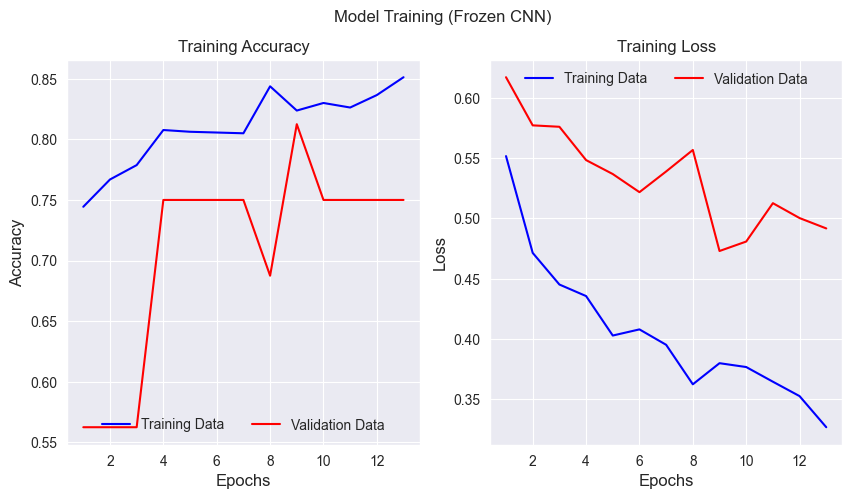

In [38]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/pneumonia_training_frozencnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [39]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.weights.h5', overwrite=True)

In [40]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 624 images belonging to 2 classes.


In [41]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.weights.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.4917
  1/624 ━━━━━━━━━━━━━━━━━━━━ 1:47 172ms/step - accuracy: 1.0000 - loss: 0.2074

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.7316 - loss: 0.5544
Validation loss:     0.4917
Validation accuracy: 0.7500
Test loss:           0.4371
Test accuracy:       0.8173


In [42]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

624/624 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step


In [43]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['NORMAL', 'PNEUMONIA']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])

              precision    recall  f1-score   support

      NORMAL       0.82      0.65      0.73       234
   PNEUMONIA       0.82      0.92      0.86       390

    accuracy                           0.82       624
   macro avg       0.82      0.78      0.80       624
weighted avg       0.82      0.82      0.81       624



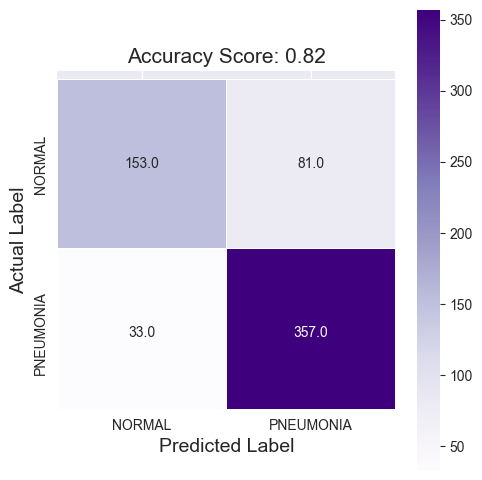

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

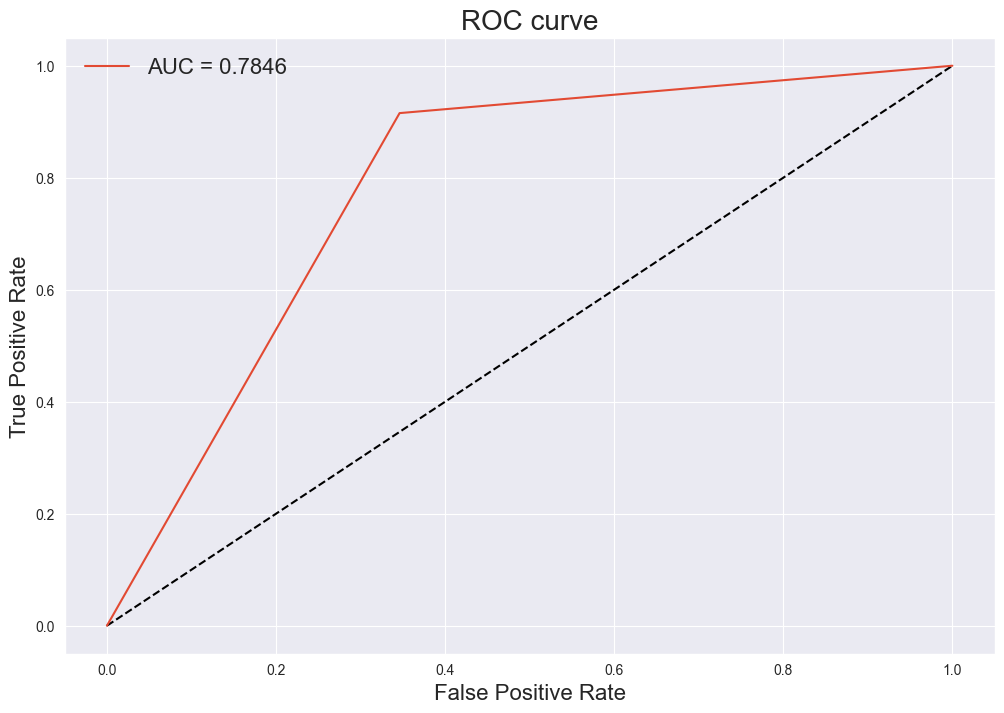

In [45]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Incremental unfreezing and fine-tuning

In [46]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [47]:
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [48]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8081 - loss: 0.3953
Epoch 1: val_loss improved from 0.47301 to 0.40025, saving model to models/pneumonia.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8079 - loss: 0.3963 - val_accuracy: 0.8125 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7968 - loss: 0.3885
Epoch 2: val_loss did not improve from 0.40025
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7965 - loss: 0.3918 - val_accuracy: 0.5000 - val_loss: 1.1669 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8564 - loss: 0.3402
Epoch 3: val_loss did not improve from 0.40025
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8558 - loss: 0.3393 - val_accuracy: 0.6875 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8606 - loss: 0.3587
Epoch 4: val_loss did not improve from 0.40025

Epoch 4: ReduceLRO

In [49]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.weights.h5', overwrite=True)

# Evaluating the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.5573
624/624 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.7967 - loss: 0.4621
Validation loss:     0.5572949647903442
Validation accuracy: 0.75
Test loss:           0.35487234592437744
Test accuracy:       0.8573718070983887
624/624 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step
              precision    recall  f1-score   support

     healthy       0.91      0.69      0.78       234
    infected       0.84      0.96      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.82      0.84       624
weighted avg       0.86      0.86      0.85       624



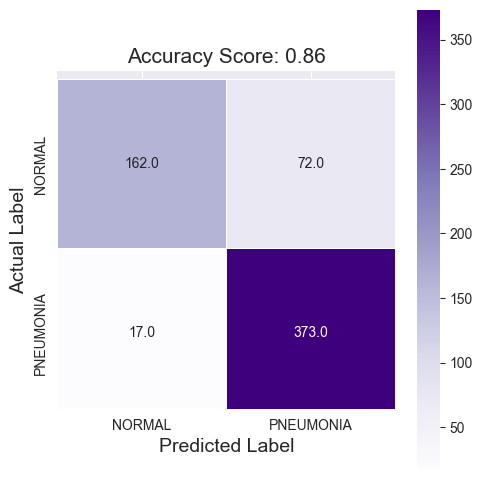

In [50]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

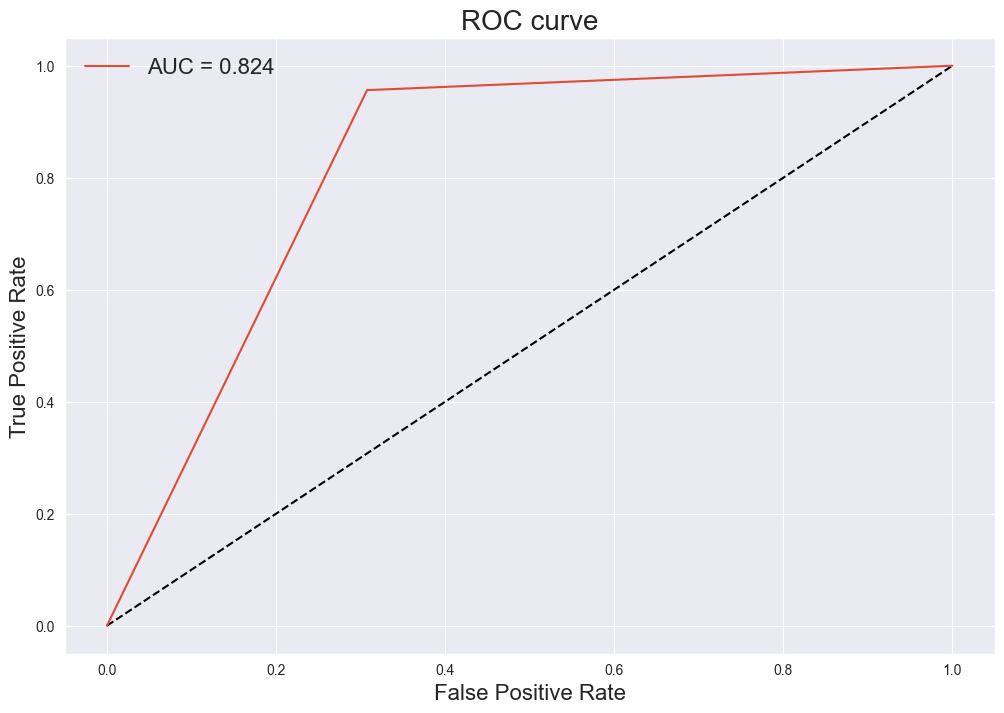

In [51]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# Unfreezing and fine-tuning the entire network[link text

In [52]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\divyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [53]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8838 - loss: 0.2788
Epoch 1: val_loss did not improve from 0.40025
100/100 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - accuracy: 0.8840 - loss: 0.2785 - val_accuracy: 0.6875 - val_loss: 0.6091 - learning_rate: 1.0000e-04
Epoch 2/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 4:09 7s/step - accuracy: 0.9179 - loss: 0.2236

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss did not improve from 0.40025
100/100 ━━━━━━━━━━━━━━━━━━━━ 425s 4s/step - accuracy: 0.9174 - loss: 0.2213 - val_accuracy: 0.6875 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9232 - loss: 0.1825
Epoch 3: val_loss did not improve from 0.40025
100/100 ━━━━━━━━━━━━━━━━━━━━ 828s 8s/step - accuracy: 0.9232 - loss: 0.1824 - val_accuracy: 0.6875 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 4/35
 63/100 ━━━━━━━━━━━━━━━━━━━━ 7:52 13s/step - accuracy: 0.9379 - loss: 0.1765
Epoch 4: val_loss did not improve from 0.40025
100/100 ━━━━━━━━━━━━━━━━━━━━ 801s 8s/step - accuracy: 0.9363 - loss: 0.1746 - val_accuracy: 0.6250 - val_loss: 0.9784 - learning_rate: 1.0000e-04
Epoch 4: early stopping


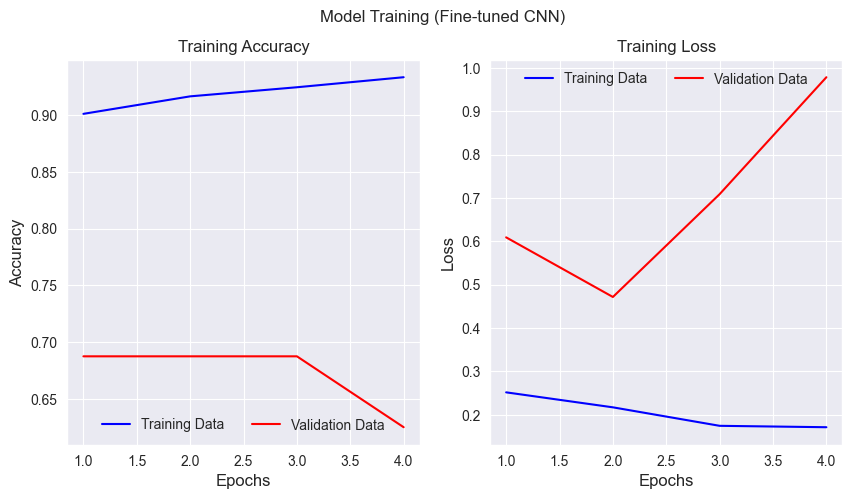

In [54]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/pneumonia_training_finetunedcnn.jpeg", format='jpeg', dpi=400, bbox_inches='tight')

In [55]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.weights.h5', overwrite=True)

# Evaluating the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6250 - loss: 0.9784
624/624 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.5761 - loss: 1.1678
Validation loss     :0.9784
Validation accuracy :0.6250
Test loss           :0.6784
Test accuracy       :0.7580
624/624 ━━━━━━━━━━━━━━━━━━━━ 93s 148ms/step
              precision    recall  f1-score   support

     healthy       0.99      0.36      0.53       234
    infected       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



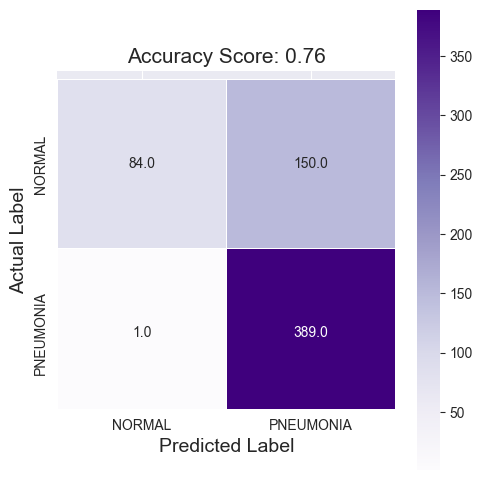

In [56]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.weights.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['NORMAL', 'PNEUMONIA'], 
                        columns=['NORMAL', 'PNEUMONIA'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

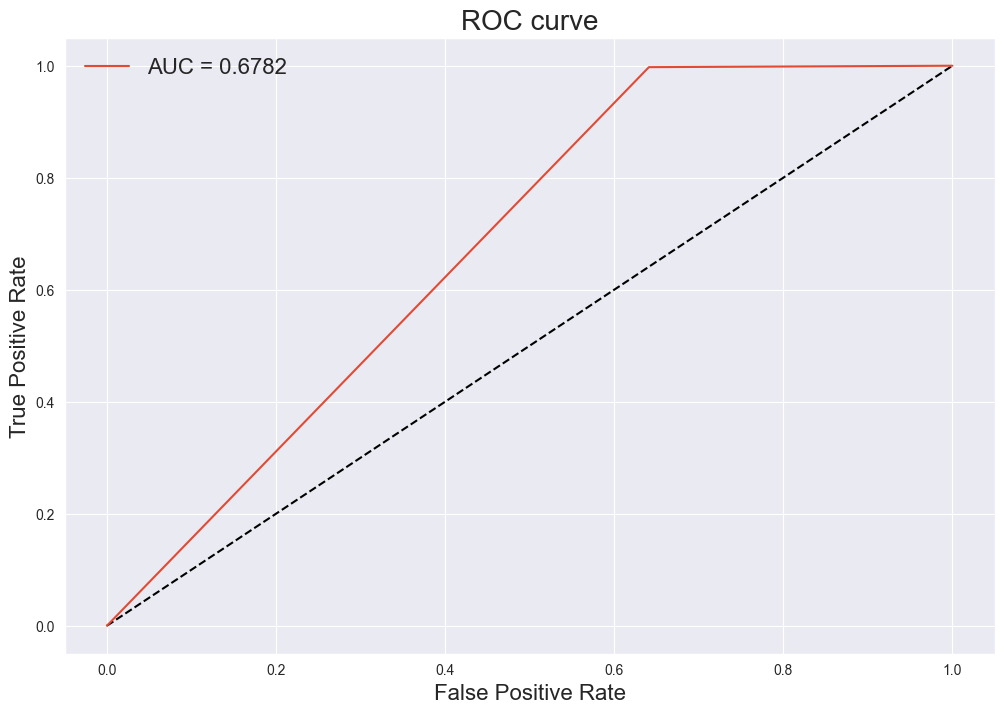

In [57]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

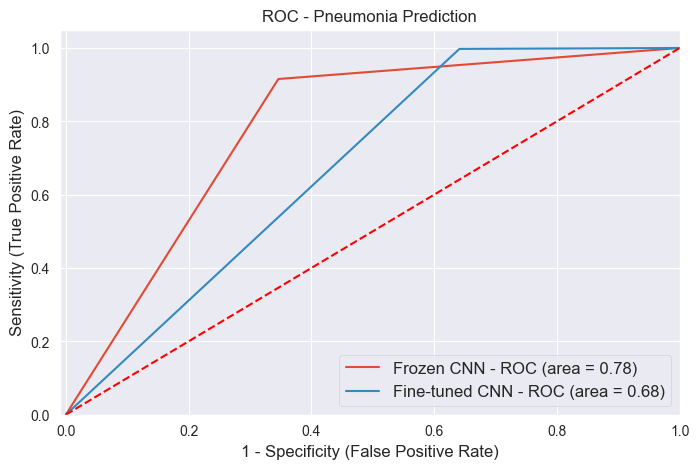

In [58]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']  
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Pneumonia Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("outputs/roc_pneumonia.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[80.13, 91.35]
[75.21, 89.15]


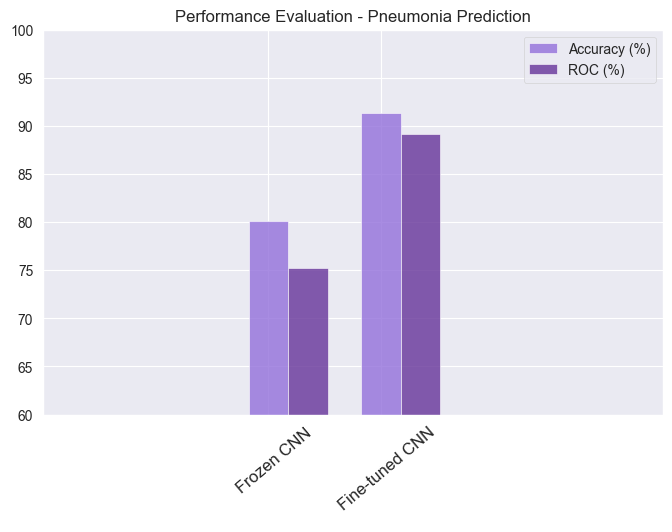

In [59]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test accuracy       :0.8013
# ROC                 :0.7521

# Test accuracy       :0.9135
# ROC                 :0.8915

means_roc = [75.21, 89.15]
means_accuracy = [80.13, 91.35]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity, 
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("outputs/PE_pneumonia.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

[43.31, 30.56]


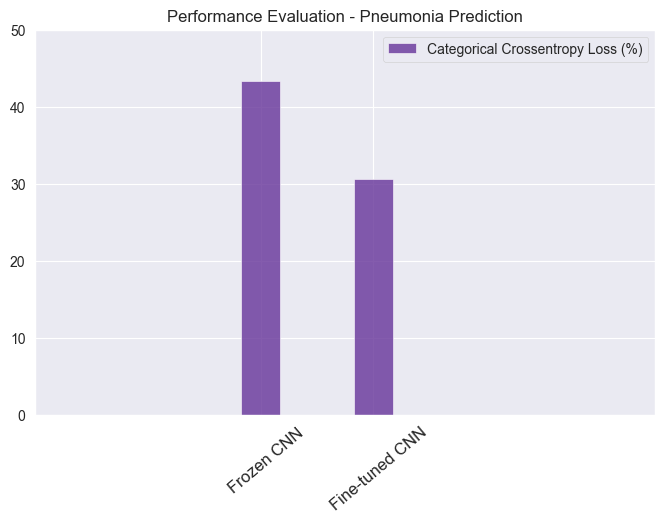

In [60]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

# Test loss           :0.4331
# Test loss           :0.3056

means_loss = [43.31, 30.56]

print(means_loss)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Pneumonia Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("outputs/PE_pneumonia2.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Prediction results for 10 randomly selected images

In [61]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


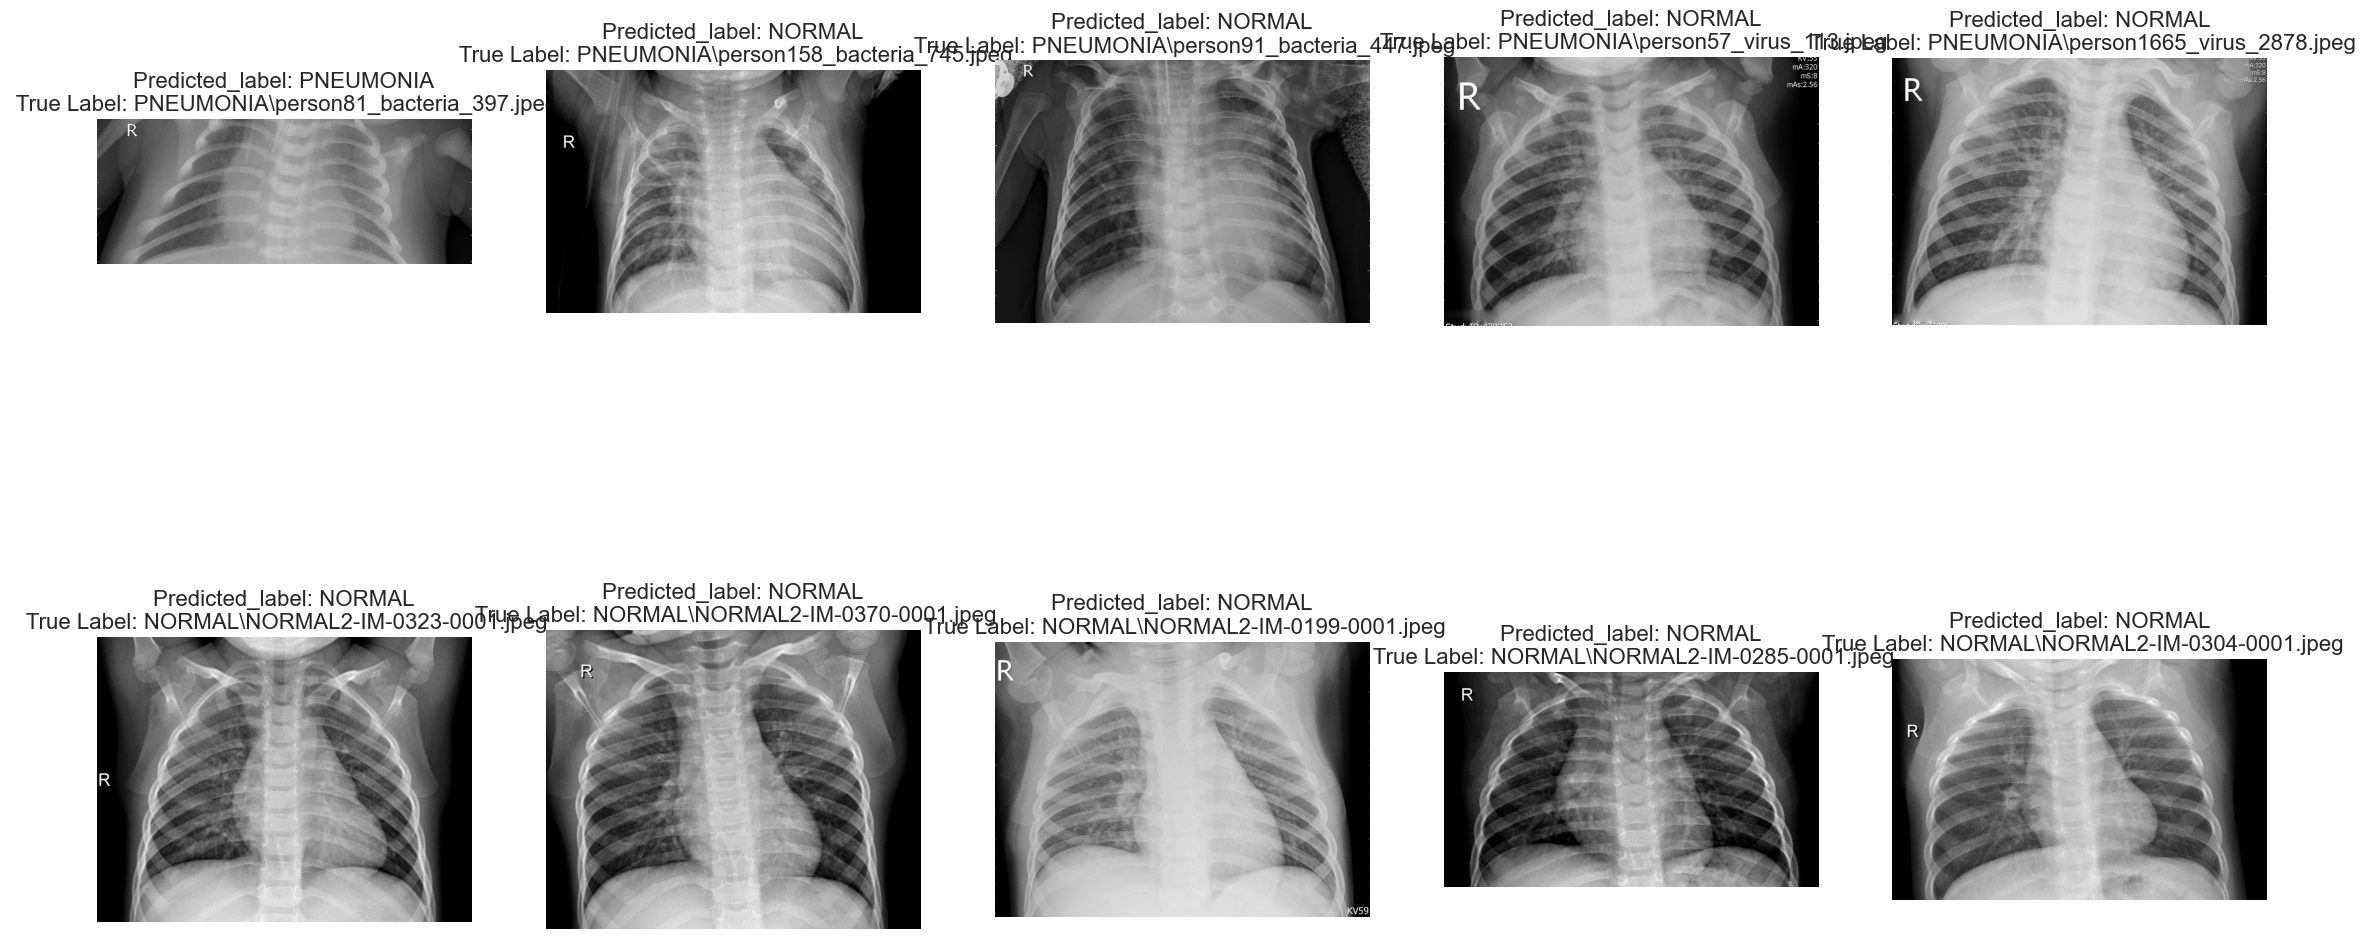

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128,128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=16)
plt.savefig("outputs/pneumonia_predictions.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()